

# Frequency-tagging: Basic analysis of an SSVEP/vSSR dataset

In this tutorial we compute the frequency spectrum and quantify signal-to-noise
ratio (SNR) at a target frequency in EEG data recorded during fast periodic
visual stimulation (FPVS) at 12 Hz and 15 Hz in different trials.
Extracting SNR at stimulation frequency is a simple way to quantify frequency
tagged responses in MEEG (a.k.a. steady state visually evoked potentials,
SSVEP, or visual steady-state responses, vSSR in the visual domain,
or auditory steady-state responses, ASSR in the auditory domain).

For a general introduction to the method see
[Norcia et al. (2015)](https://doi.org/10.1167/15.6.4) for the visual domain,
and [Picton et al. (2003)](https://doi.org/10.3109/14992020309101316) for
the auditory domain.

**Data and outline:**

We use a simple example dataset with frequency tagged visual stimulation:
N=2 participants observed checkerboard patterns inverting with a constant
frequency of either 12.0 Hz of 15.0 Hz.
32 channels wet EEG was recorded.
(see `ssvep-dataset` for more information).

We will visualize both the power-spectral density (PSD) and the SNR
spectrum of the epoched data,
extract SNR at stimulation frequency,
plot the topography of the response,
and statistically separate 12 Hz and 15 Hz responses in the different trials.
Since the evoked response is mainly generated in early visual areas of the
brain the statistical analysis will be carried out on an occipital
ROI.


In [3]:
# Authors: Dominik Welke <dominik.welke@web.de>
#          Evgenii Kalenkovich <e.kalenkovich@gmail.com>

# Adapted for Liverpool workshop by Carina Forster
# Date: 2024-06-27

# License: BSD-3-Clause
# Copyright the MNE-Python contributors.

In [13]:
import matplotlib.pyplot as plt
import mne
import scipy

## Data preprocessing
Due to a generally high SNR in SSVEP/vSSR, typical preprocessing steps
are considered optional. This doesn't mean, that a proper cleaning would not
increase your signal quality!

* Raw data have FCz reference, so we will apply common-average rereferencing.

* We  will apply a 0.1 highpass filter.

* Lastly, we will cut the data in 20 s epochs corresponding to the trials.





In [8]:
# Load raw data
data_path = mne.datasets.ssvep.data_path()
bids_fname = (
    data_path / "sub-02" / "ses-01" / "eeg" / "sub-02_ses-01_task-ssvep_eeg.vhdr"
)

raw = mne.io.read_raw_brainvision(bids_fname, preload=True, verbose=False)

# Set montage
montage = mne.channels.make_standard_montage("easycap-M1")
raw.set_montage(montage, verbose=False)

# find events for 12 and 15 Hz stimulation
# Construct epochs
raw.annotations.rename({"Stimulus/S255": "12hz", "Stimulus/S155": "15hz"})

Measurement date,"September 27, 2018 14:48:36 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,35 points
Good channels,32 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,1000.00 Hz
Highpass,0.02 Hz
Lowpass,1000.00 Hz


<div class="alert alert-block alert-success">
<b>Exercise:</b> set average referece, high-pass filter the data with 0.1 Hz and create epochs betweem -1 and 20 seconds centered around stimulation onset, with no baseline.
</div>

In [9]:

# Set common average reference
raw.set_eeg_reference("average", projection=False, verbose=False)

# Apply bandpass filter
raw.filter(l_freq=0.1, h_freq=None, fir_design="firwin", verbose=False)

# Construct epochs
tmin, tmax = -1.0, 20.0  # in s
baseline = None

epochs = mne.Epochs(
    raw,
    event_id=["12hz", "15hz"],
    tmin=tmin,
    tmax=tmax,
    baseline=baseline,
    verbose=False,
)

## Frequency analysis
Now we compute the frequency spectrum of the EEG data.
You will already see the peaks at the stimulation frequencies and some of
their harmonics, without any further processing.

The 'classical' PSD plot will be compared to a plot of the SNR spectrum.
SNR will be computed as a ratio of the power in a given frequency bin
to the average power in its neighboring bins.
This procedure has two advantages over using the raw PSD:

* it normalizes the spectrum and accounts for 1/f power decay.

* power modulations which are not very narrow band will disappear.

### Calculate power spectral density (PSD)
The frequency spectrum will be computed using Fast Fourier transform (FFT).
This seems to be common practice in the steady-state literature and is
based on the exact knowledge of the stimulus and the assumed response -
especially in terms of it's stability over time.
For a discussion see e.g.
[Bach & Meigen (1999)](https://doi.org/10.1023/A:1002648202420)

We will exclude the first second of each trial from the analysis:

* steady-state response often take a while to stabilize, and the
  transient phase in the beginning can distort the signal estimate.

* this section of data is expected to be dominated by responses related to
  the stimulus onset, and we are not interested in this.

In MNE we call plain FFT as a special case of Welch's method, with only a
single Welch window spanning the entire trial and no specific windowing
function (i.e. applying a boxcar window).




In [10]:
tmin = 1.0
tmax = 20.0
fmin = 1.0
fmax = 40
sfreq = epochs.info["sfreq"]

spectrum = epochs.compute_psd(
    "welch",
    n_fft=int(sfreq * (tmax - tmin)),
    n_overlap=0,
    n_per_seg=None,
    tmin=tmin,
    tmax=tmax,
    fmin=fmin,
    fmax=fmax,
    window="boxcar",
    verbose=False,
)
psds_fft, freqs_fft = spectrum.get_data(return_freqs=True)

<div class="alert alert-block alert-success">
<b>Exercise:</b> Compare the PSDs estimated with Welch method or Multitaper method instead of FFT
</div>

In [11]:
# Welch
spectrum_welch = epochs.compute_psd(
    "welch",
    n_fft=int(sfreq * (tmax - tmin)),
    n_overlap=0,
    n_per_seg=None,
    tmin=tmin,
    tmax=tmax,
    fmin=fmin,
    fmax=fmax,
    window="hamming", # this is the MNE default, so we would not need to specify it
    verbose=False,
)

psds_welch, freqs_welch = spectrum_welch.get_data(return_freqs=True)

# Multitaper

spectrum_multitaper = epochs.compute_psd(
    "multitaper",
    tmin=tmin,
    tmax=tmax,
    fmin=fmin,
    fmax=fmax,
    verbose=False,
)

psds_multitaper, freqs_multitaper = spectrum_multitaper.get_data(return_freqs=True)

<div class="alert alert-block alert-info">
<b>Bonus:</b> plot the 3 PSDs (Welch, Multitaper und FFT in one plot and compare them (use decibel instead of power). What do you notice?  <br>
Plot raw power instead. Hint: plot 3 subplots in one figure.
</div>


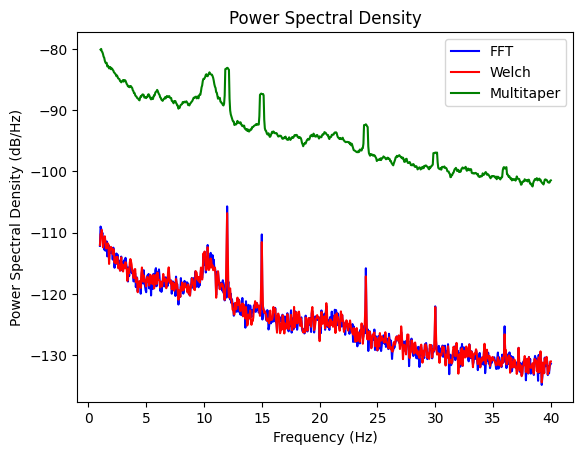

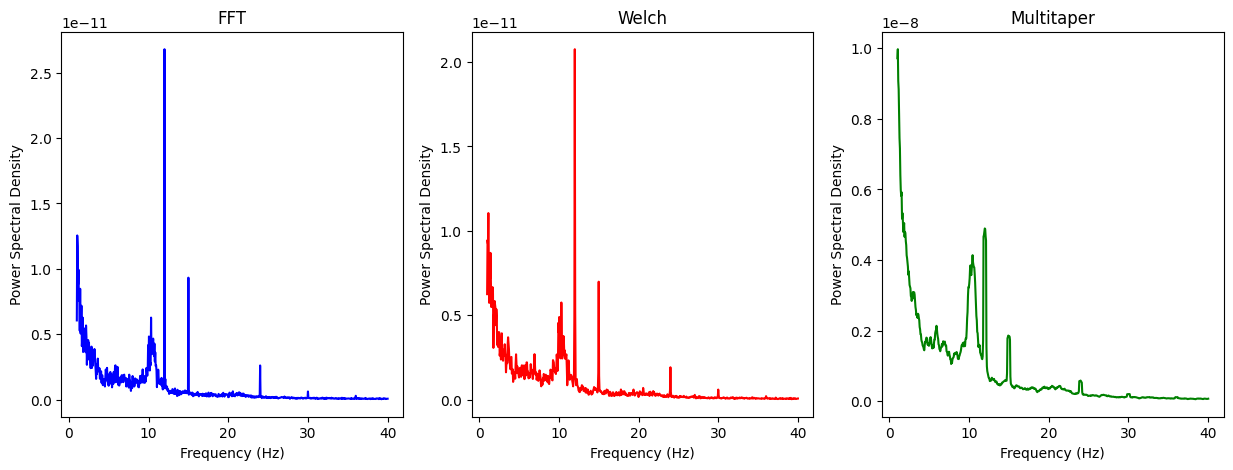

In [37]:
ch_index_vis = epochs.ch_names.index['Oz'] # select visual channel

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(freqs_fft, 10 * np.log10(np.mean(psds_fft[:,ch_index_vis,:], axis=0)), color="b", label="FFT")
ax.plot(freqs_welch, 10 * np.log10(np.mean(psds_welch[:,ch_index_vis,:], axis=0)), color="r", label="Welch")
ax.plot(
    freqs_multitaper, 10 * np.log10(np.mean(psds_multitaper[:,ch_index_vis,:], axis=0)), color="g", label="Multitaper"
)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power Spectral Density (dB/Hz)")
ax.set_title("Power Spectral Density")
ax.legend()
plt.show()

# without decibel scale but plot 3 separate plots next to each other in one figure
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(freqs_fft, np.mean(psds[:,ch_index_vis,:], axis=0), color="b")
axs[0].set_title("FFT")
axs[0].set_xlabel("Frequency (Hz)")
axs[0].set_ylabel("Power Spectral Density")
axs[1].plot(freqs_welch, np.mean(psds_welch[:,ch_index_vis,:], axis=0), color="r")
axs[1].set_title("Welch")
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_ylabel("Power Spectral Density")
axs[2].plot(freqs_multitaper, np.mean(psds_multitaper[:,ch_index_vis,:], axis=0), color="g")
axs[2].set_title("Multitaper")
axs[2].set_xlabel("Frequency (Hz)")
axs[2].set_ylabel("Power Spectral Density")
plt.show()

<div class="alert alert-block alert-warning">
<b>Discussion:</b> Do you see the stimulation peaks? 

Why is there a peak at 24 and 30 Hz? 
</div>

### Calculate signal to noise ratio (SNR)

SNR - as we define it here - is a measure of relative power:
it's the ratio of power in a given frequency bin - the 'signal' -
to a 'noise' baseline - the average power in the surrounding frequency bins.
This approach was initially proposed by
[Meigen & Bach (1999)](https://doi.org/10.1023/A:1002097208337)

Hence, we need to set some parameters for this baseline - how many
neighboring bins should be taken for this computation, and do we want to skip
the direct neighbors (this can make sense if the stimulation frequency is not
super constant, or frequency bands are very narrow).

The function below does what we want.




In [31]:
def snr_spectrum(psd, noise_n_neighbor_freqs=1, noise_skip_neighbor_freqs=1):
    """Compute SNR spectrum from PSD spectrum using convolution.

    Parameters
    ----------
    psd : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Data object containing PSD values. Works with arrays as produced by
        MNE's PSD functions or channel/trial subsets.
    noise_n_neighbor_freqs : int
        Number of neighboring frequencies used to compute noise level.
        increment by one to add one frequency bin ON BOTH SIDES
    noise_skip_neighbor_freqs : int
        set this >=1 if you want to exclude the immediately neighboring
        frequency bins in noise level calculation

    Returns
    -------
    snr : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Array containing SNR for all epochs, channels, frequency bins.
        NaN for frequencies on the edges, that do not have enough neighbors on
        one side to calculate SNR.
    """
    # Construct a kernel that calculates the mean of the neighboring
    # frequencies
    averaging_kernel = np.concatenate(
        (
            np.ones(noise_n_neighbor_freqs),
            np.zeros(2 * noise_skip_neighbor_freqs + 1),
            np.ones(noise_n_neighbor_freqs),
        )
    )
    averaging_kernel /= averaging_kernel.sum()

    # Calculate the mean of the neighboring frequencies by convolving with the
    # averaging kernel.
    mean_noise = np.apply_along_axis(
        lambda psd_: np.convolve(psd_, averaging_kernel, mode="valid"), axis=-1, arr=psd
    )

    # The mean is not defined on the edges so we will pad it with nas. The
    # padding needs to be done for the last dimension only so we set it to
    # (0, 0) for the other ones.
    edge_width = noise_n_neighbor_freqs + noise_skip_neighbor_freqs
    pad_width = [(0, 0)] * (mean_noise.ndim - 1) + [(edge_width, edge_width)]
    mean_noise = np.pad(mean_noise, pad_width=pad_width, constant_values=np.nan)

    return psd / mean_noise

Now we call the function to compute our SNR spectrum.

As described above, we have to define two parameters.

* how many noise bins do we want?

* do we want to skip the n bins directly next to the target bin?


Tweaking these parameters *can* drastically impact the resulting spectrum,
but mainly if you choose extremes.
E.g. if you'd skip very many neighboring bins, broad band power modulations
(such as the alpha peak) should reappear in the SNR spectrum.
On the other hand, if you skip none you might miss or smear peaks if the
induced power is distributed over two or more frequency bins (e.g. if the
stimulation frequency isn't perfectly constant, or you have very narrow
bins).

Here, we want to compare power at each bin with average power of the
**three neighboring bins** (on each side) and **skip one bin** directly next
to it.




In [32]:
snrs = snr_spectrum(psds_fft, noise_n_neighbor_freqs=3, noise_skip_neighbor_freqs=1)

### Plot PSD and SNR spectra
Now we will plot grand average PSD (in blue) and SNR (in red) ± sd
for every frequency bin.
PSD is plotted on a log scale.




C:\Users\Carina\AppData\Local\Temp\ipykernel_38540\1298182157.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


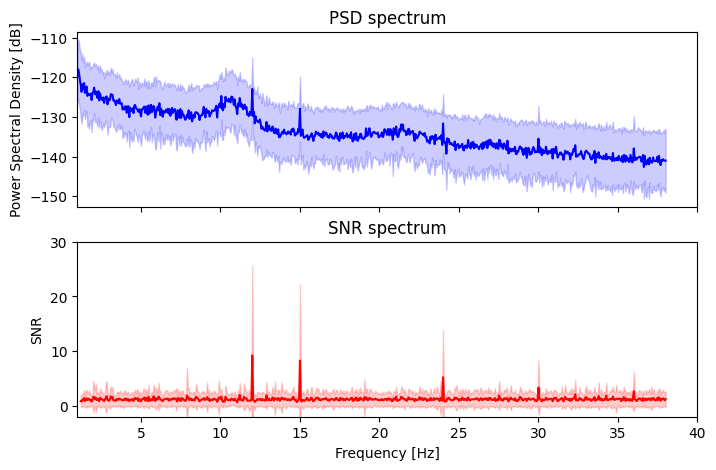

In [33]:
fig, axes = plt.subplots(2, 1, sharex="all", sharey="none", figsize=(8, 5))
freq_range = range(
    np.where(np.floor(freqs_fft) == 1.0)[0][0], np.where(np.ceil(freqs_fft) == fmax - 1)[0][0]
)

psds_plot = 10 * np.log10(psds_fft) # decibel conversion
psds_mean = psds_plot.mean(axis=(0, 1))[freq_range]
psds_std = psds_plot.std(axis=(0, 1))[freq_range]
axes[0].plot(freqs_fft[freq_range], psds_mean, color="b")
axes[0].fill_between(
    freqs[freq_range], psds_mean - psds_std, psds_mean + psds_std, color="b", alpha=0.2
)
axes[0].set(title="PSD spectrum", ylabel="Power Spectral Density [dB]")

# SNR spectrum
snr_mean = snrs.mean(axis=(0, 1))[freq_range]
snr_std = snrs.std(axis=(0, 1))[freq_range]

axes[1].plot(freqs_fft[freq_range], snr_mean, color="r")
axes[1].fill_between(
    freqs_fft[freq_range], snr_mean - snr_std, snr_mean + snr_std, color="r", alpha=0.2
)
axes[1].set(
    title="SNR spectrum",
    xlabel="Frequency [Hz]",
    ylabel="SNR",
    ylim=[-2, 30],
    xlim=[fmin, fmax],
)
fig.show()

<div class="alert alert-block alert-success">
<b>Exercise:</b> Where in the code do we see the standard deviation added to the plots?
</div>

You can see that the peaks at the stimulation frequencies (12 Hz, 15 Hz)
and their harmonics are visible in both plots.
Yet, the SNR spectrum shows them more prominently as peaks from a
noisy but more or less constant baseline of SNR = 1.
You can further see that the SNR processing removes any broad-band power
differences (such as the increased power in alpha band around 10 Hz),
and also removes the 1/f decay in the PSD.

Note, that while the SNR plot implies the possibility of values below 0
(mean minus sd) such values do not make sense.
Each SNR value is a ratio of positive PSD values, and the lowest possible PSD
value is 0 (negative Y-axis values in the upper panel only result from
plotting PSD on a log scale).
Hence SNR values must be positive and can minimally go towards 0.

## Extract SNR values at the stimulation frequency

Our processing yielded a large array of many SNR values for each trial ×
channel × frequency-bin of the PSD array.

For statistical analysis we obviously need to define specific subsets of this
array. First of all, we are only interested in SNR at the stimulation
frequency, but we also want to restrict the analysis to a spatial ROI.
Lastly, answering your interesting research questions will probably rely on
comparing SNR in different trials.

Therefore we will have to find the indices of trials, channels, etc.
Alternatively, one could subselect the trials already at the epoching step,
using MNE's event information, and process different epoch structures
separately.

Let's only have a look at the trials with 12 Hz stimulation, for now.




In [38]:
# define stimulation frequency
stim_freq = 12.0

### Get index for the stimulation frequency (12 Hz)
Ideally, there would be a bin with the stimulation frequency exactly in its
center. However, depending on your Spectral decomposition this is not
always the case. We will find the bin closest to it - this one should contain
our frequency tagged response.




In [39]:
# find index of frequency bin closest to stimulation frequency
i_bin_12hz = np.argmin(abs(freqs_fft - stim_freq))
# could be updated to support multiple frequencies

# for later, we will already find the 15 Hz bin and the 1st and 2nd harmonic
# for both.
i_bin_24hz = np.argmin(abs(freqs_fft - 24))
i_bin_36hz = np.argmin(abs(freqs_fft - 36))
i_bin_15hz = np.argmin(abs(freqs_fft - 15))
i_bin_30hz = np.argmin(abs(freqs_fft - 30))
i_bin_45hz = np.argmin(abs(freqs_fft - 45))

### Get indices for the different trial types



<div class="alert alert-block alert-success">
<b>Exercise:</b> Can you get the indices for the epochs that contain a 12 or 15 Hz stimulation?
Store them in i_trial_12hz and i_trial_15Hz.
</div>

In [41]:
i_trial_12hz = np.where(epochs.annotations.description == "12hz")[0]
i_trial_15hz = np.where(epochs.annotations.description == "15hz")[0]

### Get indices of EEG channels forming the ROI



In [42]:
# Define different ROIs
roi_vis = [
    "POz",
    "Oz",
    "O1",
    "O2",
    "PO3",
    "PO4",
    "PO7",
    "PO8",
    "PO9",
    "PO10",
    "O9",
    "O10",
]  # visual roi

# Find corresponding indices using mne.pick_types()
picks_roi_vis = mne.pick_types(
    epochs.info, eeg=True, stim=False, exclude="bads", selection=roi_vis
)

### Apply the subset, and check the result
Now we simply need to apply our selection and yield a result. Therefore, we typically report grand average SNR over the subselection.

In [49]:
snrs_target = snrs[i_trial_12hz, :, i_bin_12hz][:, picks_roi_vis]
print("sub 2, 12 Hz trials, SNR at 12 Hz")
print(f"average SNR (occipital ROI): {snrs_target.mean()}")

sub 2, 12 Hz trials, SNR at 12 Hz
average SNR (occipital ROI): 41.69365541718619


## Topography of the vSSR
But wait...
As described in the intro, we have decided *a priori* to work with average
SNR over a subset of occipital channels - a visual region of interest (ROI)
- because we expect SNR to be higher on these channels than in other
channels.

Let's check out, whether this was a good decision!

Here we will plot average SNR for each channel location as a topoplot.
Then we will do a simple paired T-test to check, whether average SNRs over
over the visual ROI is higher than over all channels.

=> this is bad as we are double dipping here




In [12]:
# get average SNR at 12 Hz for ALL channels
snrs_12hz = snrs[i_trial_12hz, :, i_bin_12hz]
snrs_12hz_chaverage = snrs_12hz.mean(axis=0)

# plot SNR topography
fig, ax = plt.subplots(1)
mne.viz.plot_topomap(snrs_12hz_chaverage, epochs.info, vlim=(1, None), axes=ax)

print("sub 2, 12 Hz trials, SNR at 12 Hz")
print(f"average SNR (all channels): {snrs_12hz_chaverage.mean()}")
print(f"average SNR (occipital ROI): {snrs_target.mean()}")

tstat_roi_vs_scalp = scipy.stats.ttest_rel(snrs_target.mean(axis=1), snrs_12hz.mean(axis=1))
print(
    "12 Hz SNR in occipital ROI is significantly larger than 12 Hz SNR over all "
    f"channels: t = {tstat_roi_vs_scalp[0]:.3f}, p = {tstat_roi_vs_scalp[1]}"
)

NameError: name 'snrs' is not defined

We can see, that 1) this participant indeed exhibits a cluster of channels
with high SNR in the occipital region and 2) that the average SNR over all
channels is smaller than the average of the visual ROI computed above.
The difference is statistically significant. Great!

Such a topography plot can be a nice tool to explore and play with your data
- e.g. you could try how changing the reference will affect the spatial
distribution of SNR values.

However, we also wanted to show this plot to point at a potential
problem with frequency-tagged (or any other brain imaging) data:
there are many channels and somewhere you will likely find some
statistically significant effect.
It is very easy - even unintended - to end up double-dipping or p-hacking.
So if you want to work with an ROI or individual channels, ideally select
them *a priori* - before collecting or looking at the data - and preregister
this decision so people will believe you.
If you end up selecting an ROI or individual channel for reporting *because
this channel or ROI shows an effect*, e.g. in an explorative analysis, this
is also fine but make it transparently and correct for multiple comparison.

## Statistical separation of 12 Hz and 15 Hz vSSR
After this little detour into open science, let's move on and
do the analyses we actually wanted to do:

We will show that we can easily detect and discriminate the brains responses
in the trials with different stimulation frequencies.

In the frequency and SNR spectrum plot above, we had all trials mixed up.
Now we will extract 12 and 15 Hz SNR in both types of trials individually,
and compare the values with a simple t-test.
We will also extract SNR of the 1st and 2nd harmonic for both stimulation
frequencies. These are often reported as well and can show interesting
interactions.




C:\Users\Carina\AppData\Local\Temp\ipykernel_38540\265664940.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


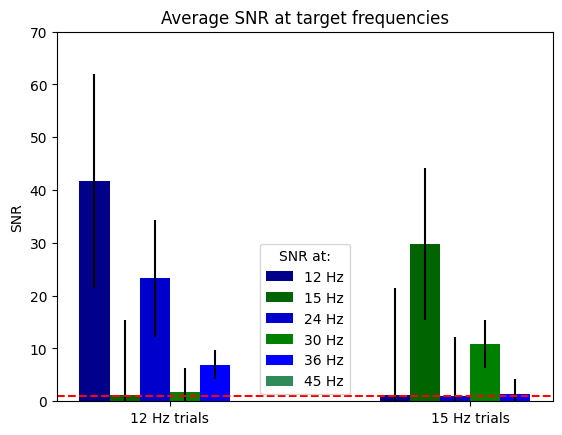

In [51]:
snrs_roi = snrs[:, picks_roi_vis, :].mean(axis=1)

freq_plot = [12, 15, 24, 30, 36, 45]
color_plot = ["darkblue", "darkgreen", "mediumblue", "green", "blue", "seagreen"]
xpos_plot = [-5.0 / 12, -3.0 / 12, -1.0 / 12, 1.0 / 12, 3.0 / 12, 5.0 / 12]
fig, ax = plt.subplots()
labels = ["12 Hz trials", "15 Hz trials"]
x = np.arange(len(labels))  # the label locations
width = 0.6  # the width of the bars
res = dict()

# loop to plot SNRs at stimulation frequencies and harmonics
for i, f in enumerate(freq_plot):
    # extract snrs
    stim_12hz_tmp = snrs_roi[i_trial_12hz, np.argmin(abs(freqs_fft - f))]
    stim_15hz_tmp = snrs_roi[i_trial_15hz, np.argmin(abs(freqs_fft - f))]
    SNR_tmp = [stim_12hz_tmp.mean(), stim_15hz_tmp.mean()]
    # plot (with std)
    ax.bar(
        x + width * xpos_plot[i],
        SNR_tmp,
        width / len(freq_plot),
        yerr=np.std(SNR_tmp),
        label="%i Hz SNR" % f,
        color=color_plot[i],
    )
    # store results for statistical comparison
    res["stim_12hz_snrs_%ihz" % f] = stim_12hz_tmp
    res["stim_15hz_snrs_%ihz" % f] = stim_15hz_tmp

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("SNR")
ax.set_title("Average SNR at target frequencies")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(["%i Hz" % f for f in freq_plot], title="SNR at:")
ax.set_ylim([0, 70])
ax.axhline(1, ls="--", c="r")
fig.show()

<div class="alert alert-block alert-warning">
<b>Discussion:</b> Interpret the plot. What is the main message? Why are we looking at the harmonics?  
</div>

## Debriefing
So that's it, we hope you enjoyed our little tour through this example
dataset.

As you could see, frequency-tagging is a very powerful tool that can yield
very high signal to noise ratios and effect sizes that enable you to detect
brain responses even within a single participant and single trials of only
a few seconds duration.

## Bonus exercises
For the overly motivated amongst you, let's see what else we can show with
these data.

Using the PSD function as implemented in MNE makes it very easy to change
the amount of data that is actually used in the spectrum
estimation.

Here we employ this to show you some features of frequency
tagging data that you might or might not have already intuitively expected:

### Effect of trial duration on SNR
First we will simulate shorter trials by taking only the first x s of our 20s
trials (2, 4, 6, 8, ..., 20 s), and compute the SNR using a FFT window
that covers the entire epoch:




C:\Users\Carina\AppData\Local\Temp\ipykernel_38540\3670991554.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(window_snrs, labels=window_lengths, vert=True)
C:\Users\Carina\AppData\Local\Temp\ipykernel_38540\3670991554.py:54: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


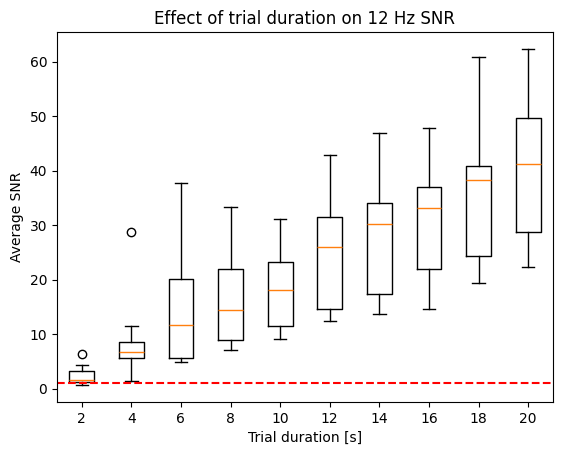

In [52]:
stim_bandwidth = 0.5

# shorten data and welch window
window_lengths = [i for i in range(2, 21, 2)]
window_snrs = [[]] * len(window_lengths)
for i_win, win in enumerate(window_lengths):
    # compute spectrogram
    this_spectrum = epochs["12hz"].compute_psd(
        "welch",
        n_fft=int(sfreq * win),
        n_overlap=0,
        n_per_seg=None,
        tmin=0,
        tmax=win,
        window="boxcar",
        fmin=fmin,
        fmax=fmax,
        verbose=False,
    )
    windowed_psd, windowed_freqs = this_spectrum.get_data(return_freqs=True)
    # define a bandwidth of 1 Hz around stimfreq for SNR computation
    bin_width = windowed_freqs[1] - windowed_freqs[0]
    skip_neighbor_freqs = (
        round((stim_bandwidth / 2) / bin_width - bin_width / 2.0 - 0.5)
        if (bin_width < stim_bandwidth)
        else 0
    )
    n_neighbor_freqs = int(
        (
            sum((windowed_freqs <= 13) & (windowed_freqs >= 11))
            - 1
            - 2 * skip_neighbor_freqs
        )
        / 2
    )
    # compute snr
    windowed_snrs = snr_spectrum(
        windowed_psd,
        noise_n_neighbor_freqs=n_neighbor_freqs if (n_neighbor_freqs > 0) else 1,
        noise_skip_neighbor_freqs=skip_neighbor_freqs,
    )
    window_snrs[i_win] = windowed_snrs[
        :, picks_roi_vis, np.argmin(abs(windowed_freqs - 12.0))
    ].mean(axis=1)

fig, ax = plt.subplots(1)
ax.boxplot(window_snrs, tick_labels=window_lengths, vert=True)
ax.set(
    title="Effect of trial duration on 12 Hz SNR",
    ylabel="Average SNR",
    xlabel="Trial duration [s]",
)
ax.axhline(1, ls="--", c="r")
fig.show()